<a href="https://colab.research.google.com/github/macgyver121/IS_DADS/blob/main/word2vec_data%2BLSTM_adamax_acc6355.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4

# Install Library

In [1]:
pip install pythainlp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
pip install emoji

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
!pip install gensim

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import pandas as pd
import numpy as np
import re
import emoji

from pythainlp.tokenize import word_tokenize
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences

from gensim.test.utils import common_texts
from gensim.models import Word2Vec

from keras.layers import Embedding
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Bidirectional
from keras.metrics import Precision, Recall
from keras.callbacks import History

import tensorflow as tf

from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

import matplotlib.pyplot as plt

from datetime import datetime
from keras import callbacks

import keras.backend as K

# Import file

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
# import csv file
df = pd.read_csv('/content/drive/MyDrive/data_all.csv', delimiter=',')

In [7]:
df.loc[:,'text'] = df.loc[:,'text'].map(word_tokenize)

In [8]:
df

,label,text
0,1.0,[1]
1,1.0,[สวัสดี]
2,1.0,"[อรุณสวัสดิ์, , ดู, ข่าว]"
3,1.0,"[D, , jai]"
4,1.0,"[สวัสดี, ชาวโลก]"
...,...,...
11954,1.0,"[จุดแข็ง, หัว, , จุดอ่อน, ที่อยู่]"
11955,1.0,[]
11956,1.0,"[เจอ, ไฟไหม้, , โทร, แจ้ง, , เบอร์]"
11957,0.0,"[แม่, ง, เก่ง]"


## create list of text

In [9]:
sent = [row for row in df['text']]

In [10]:
# Average String lengths in list
# using map() + sum() + len()
res = sum(map(len, sent))/float(len(sent))
 
# printing result
print("The Average length of String in list is : " + str(res))

The Average length of String in list is : 5.186804916799064


## Tokenize and pad sequence

In [11]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df.text)

In [12]:
# create X
X = pad_sequences(tokenizer.texts_to_sequences(df.text), maxlen=10)
X

array([[   0,    0,    0, ...,    0,    0,  133],
       [   0,    0,    0, ...,    0,    0,   39],
       [   0,    0,    0, ...,    1,   25,   20],
       ...,
       [   0,    0,    0, ...,  692,    1,  891],
       [   0,    0,    0, ...,   19,   71,   41],
       [   0,    0,    0, ...,    0,    0, 3979]], dtype=int32)

In [13]:
# create y
y = df['label']
y.shape

(11959,)

# Load Word2Vec(TNCc5model)

In [14]:
# load pretrained model
model = Word2Vec.load("http://www.arts.chula.ac.th/ling/wp-content/uploads/TNCc5model.bin") 

In [15]:
# model.save("TNCc5model.model")

In [16]:
# model = Word2Vec.load("TNCc5model.model")

In [17]:
# create vocab_size, embedding_dim and embedding_matrix
vocab_size = len(model.wv)
embedding_dim = model.vector_size
embedding_matrix = np.zeros((vocab_size, embedding_dim))

In [ ]:
for i, word in enumerate(model.wv):
    embedding_matrix[i] = word

In [19]:
embedding_matrix[31077]

array([-0.08747477, -0.03003867,  0.0696032 ,  0.03697103, -0.04840473,
        0.04570374,  0.08035568,  0.09319719,  0.0328302 ,  0.0205396 ,
        0.05725439,  0.07493409, -0.05307385,  0.06657625,  0.02432919,
       -0.01523621, -0.03918364,  0.00505913,  0.09474613,  0.07713508,
        0.01310679,  0.01618158,  0.03159253, -0.05961249, -0.00540888,
        0.01102536,  0.03336877, -0.09733387, -0.0455462 ,  0.00984617,
        0.0461374 ,  0.04063138, -0.01614906,  0.02336541, -0.05779864,
       -0.01610914, -0.09162895, -0.06487005, -0.01570138,  0.01779037,
       -0.01921744, -0.01817694,  0.12782034,  0.0127709 , -0.00602525,
       -0.03969072,  0.01731815,  0.00555995,  0.04609034,  0.05480786,
        0.05582551, -0.02981856, -0.01753935, -0.03173018,  0.03811059,
        0.08742324, -0.03593688, -0.08428604,  0.00821297, -0.03246153,
       -0.04117111,  0.11976431, -0.02667627, -0.03977206, -0.01023334,
        0.09782189,  0.02933291, -0.05686831,  0.0734435 , -0.03

# Create model

In [74]:
embedding_layer = Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], input_length=10, trainable=False)

In [75]:
import keras
from tensorflow.keras.layers import SpatialDropout1D

In [76]:
model = Sequential()
model.add(embedding_layer)
model.add(SpatialDropout1D(0.2))
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(128))
#model.add(Bidirectional(keras.layers.LSTM(64)))
model.add(Dropout(0.2))
model.add(Dense(3, activation='softmax'))

model.compile(optimizer='adamax', loss='categorical_crossentropy', metrics=['accuracy', Precision(), Recall()])
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 10, 100)           3107800   
                                                                 
 spatial_dropout1d_2 (Spatia  (None, 10, 100)          0         
 lDropout1D)                                                     
                                                                 
 lstm_2 (LSTM)               (None, 10, 128)           117248    
                                                                 
 dropout (Dropout)           (None, 10, 128)           0         
                                                                 
 lstm_3 (LSTM)               (None, 128)               131584    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                      

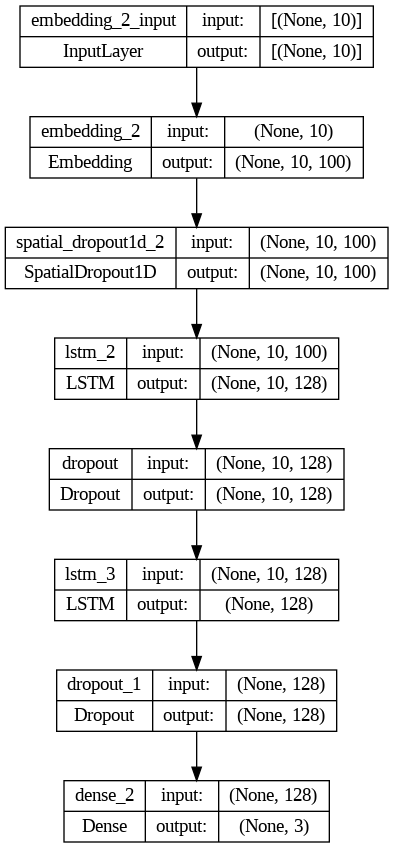

In [77]:
tf.keras.utils.plot_model(model, show_shapes=True)

# Splitting Data and prepare X and y

In [78]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [79]:
# Apply SMOTE to the training data
smote = SMOTE()
X_train_oversampled, y_train_oversampled = smote.fit_resample(X_train, y_train)

In [80]:
X_train, X_val, y_train, y_val = train_test_split(X_train_oversampled, y_train_oversampled, test_size=0.25, random_state=1)
print('Train Set ->', X_train.shape, y_train.shape)
print('Validation Set ->', X_val.shape, y_val.shape)
print('Test Set ->', X_test.shape, y_test.shape)

Train Set -> (13599, 10) (13599,)
Validation Set -> (4533, 10) (4533,)
Test Set -> (2392, 10) (2392,)


## Data distribution

<Axes: >

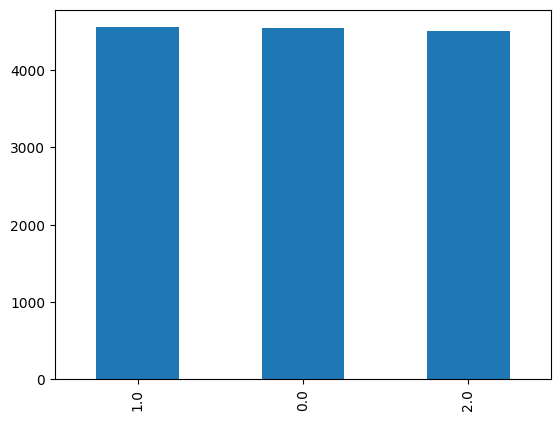

In [81]:
CountStatus = pd.value_counts(y_train.values)
CountStatus.plot.bar()

In [82]:
#CountStatus = pd.value_counts(y_val.values)
#CountStatus.plot.bar()

<Axes: >

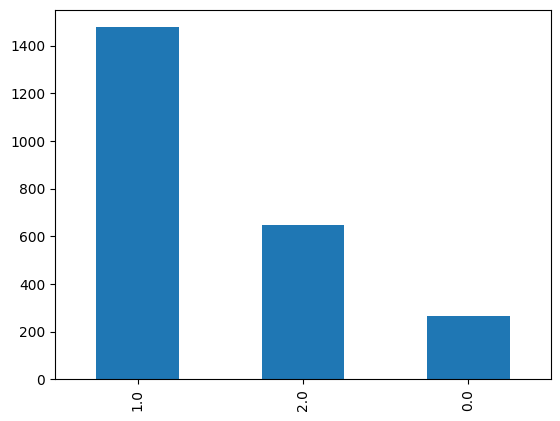

In [83]:
CountStatus = pd.value_counts(y_test.values)
CountStatus.plot.bar()

## create y to 3 output

In [84]:
y_train = pd.get_dummies(y_train)
y_val = pd.get_dummies(y_val)
y_test = pd.get_dummies(y_test)

In [85]:
print('Train Set ->', X_train.shape, y_train.shape)
print('Validation Set ->', X_val.shape, y_val.shape)
print('Test Set ->', X_test.shape, y_test.shape)

Train Set -> (13599, 10) (13599, 3)
Validation Set -> (4533, 10) (4533, 3)
Test Set -> (2392, 10) (2392, 3)


# Train Data

In [86]:
start_time = datetime.now()

checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath="weights.hdf5", monitor = 'val_accuracy', verbose=1, save_best_only=True)

history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, batch_size=16, callbacks=[checkpointer])

model.load_weights('weights.hdf5')

end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

Epoch 1/20
849/850 [============================>.] - ETA: 0s - loss: 1.0339 - accuracy: 0.4495 - precision_2: 0.6194 - recall_2: 0.1530
Epoch 1: val_accuracy improved from -inf to 0.48401, saving model to weights.hdf5
850/850 [==============================] - 33s 33ms/step - loss: 1.0338 - accuracy: 0.4495 - precision_2: 0.6197 - recall_2: 0.1530 - val_loss: 0.9982 - val_accuracy: 0.4840 - val_precision_2: 0.5787 - val_recall_2: 0.2612
Epoch 2/20
850/850 [==============================] - ETA: 0s - loss: 0.9653 - accuracy: 0.5122 - precision_2: 0.6380 - recall_2: 0.2785
Epoch 2: val_accuracy improved from 0.48401 to 0.52548, saving model to weights.hdf5
850/850 [==============================] - 26s 30ms/step - loss: 0.9653 - accuracy: 0.5122 - precision_2: 0.6380 - recall_2: 0.2785 - val_loss: 0.9490 - val_accuracy: 0.5255 - val_precision_2: 0.6358 - val_recall_2: 0.3223
Epoch 3/20
850/850 [==============================] - ETA: 0s - loss: 0.9321 - accuracy: 0.5359 - precision_2: 0.

# Save model

In [87]:
# Save the model architecture & the weights
model.save('w2v_lstm.h5')
print('Best model saved')

Best model saved


# Evaluation

In [88]:
def f1_score(precision, recall):
    ''' Function to calculate f1 score '''
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [89]:
# Evaluate model on the test set
loss, accuracy, precision, recall = model.evaluate(X_test, y_test, verbose=0)
# Print metrics
print('')
print('Accuracy  : {:.4f}'.format(accuracy))
print('Precision : {:.4f}'.format(precision))
print('Recall    : {:.4f}'.format(recall))
print('F1 Score  : {:.4f}'.format(f1_score(precision, recall)))


Accuracy  : 0.6355
Precision : 0.6690
Recall    : 0.5686
F1 Score  : 0.6147


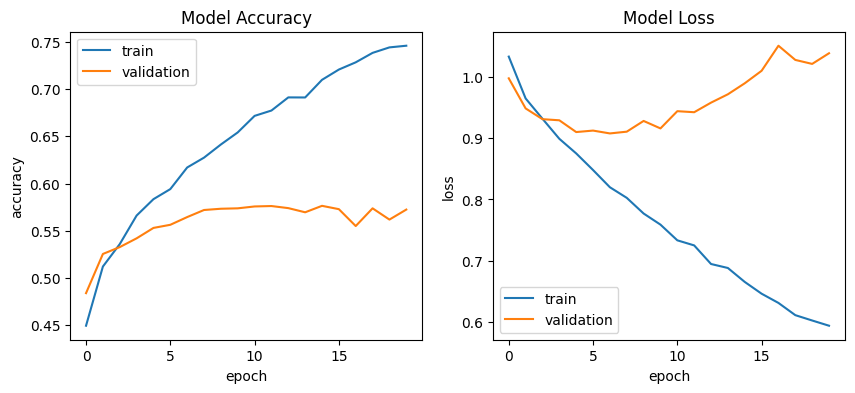

In [90]:
def plot_training_hist(history):
    '''Function to plot history for accuracy and loss'''    
    fig, ax = plt.subplots(1, 2, figsize=(10,4))
    # first plot
    ax[0].plot(history.history['accuracy'])
    ax[0].plot(history.history['val_accuracy'])
    ax[0].set_title('Model Accuracy')
    ax[0].set_xlabel('epoch')
    ax[0].set_ylabel('accuracy')
    ax[0].legend(['train', 'validation'], loc='best')
    # second plot
    ax[1].plot(history.history['loss'])
    ax[1].plot(history.history['val_loss'])
    ax[1].set_title('Model Loss')
    ax[1].set_xlabel('epoch')
    ax[1].set_ylabel('loss')
    ax[1].legend(['train', 'validation'], loc='best')
    
plot_training_hist(history)

75/75 [==============================] - 3s 28ms/step


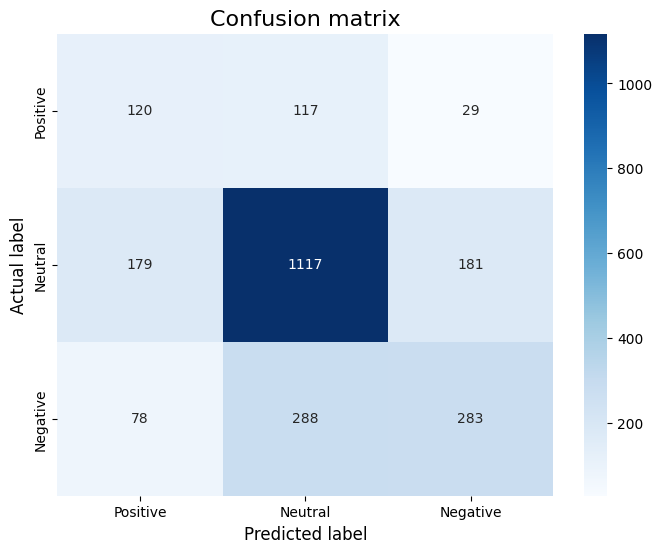

In [91]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(model, X_test, y_test):
    '''Function to plot confusion matrix for the passed model and the data'''
    
    sentiment_classes = ['Positive', 'Neutral', 'Negative']
    # use model to do the prediction
    y_pred = model.predict(X_test)
    # compute confusion matrix
    cm = confusion_matrix(np.argmax(np.array(y_test),axis=1), np.argmax(y_pred, axis=1))
    # plot confusion matrix
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, cmap=plt.cm.Blues, annot=True, fmt='d', 
                xticklabels=sentiment_classes,
                yticklabels=sentiment_classes)
    plt.title('Confusion matrix', fontsize=16)
    plt.xlabel('Predicted label', fontsize=12)
    plt.ylabel('Actual label', fontsize=12)
    
plot_confusion_matrix(model, X_test, y_test)

In [92]:
from keras.models import load_model

# Load model
model = load_model('w2v_lstm.h5')
y_pred = model.predict(X_test)

75/75 [==============================] - 2s 15ms/step


In [93]:
y_pred_lst = np.argmax(np.array(y_pred),axis=1)

In [94]:
# create y
y = df['label']
y.shape
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
y_pred_lst = list(y_pred_lst)
y_test = list(y_test.astype(int))

In [95]:
# Print the precision and recall, among other metrics
from sklearn import metrics
# Print the confusion matrix
print(confusion_matrix(y_test, y_pred_lst))

# Print the precision and recall, among other metrics
print(metrics.classification_report(y_test, y_pred_lst, digits=3))

[[ 120  117   29]
 [ 179 1117  181]
 [  78  288  283]]
              precision    recall  f1-score   support

           0      0.318     0.451     0.373       266
           1      0.734     0.756     0.745      1477
           2      0.574     0.436     0.496       649

    accuracy                          0.635      2392
   macro avg      0.542     0.548     0.538      2392
weighted avg      0.644     0.635     0.636      2392



# Inference

In [96]:
from keras.models import load_model

# Load model
model = load_model('w2v_lstm.h5')

def predict_class(text):
    '''Function to predict sentiment class of the passed text'''
    
    sentiment_classes = ['Positive', 'Neutral', 'Negative']
    max_len=10
    
    # Transforms text to a sequence of integers using a tokenizer object
    t = [text]
    df2 = pd.DataFrame(list(t), columns = ['text'])
    df2.loc[:,'text'] = df2.loc[:,'text'].map(word_tokenize)
    # Pad sequences to the same length
    X = pad_sequences(tokenizer.texts_to_sequences(df2.text), maxlen=10)
    # Do the prediction using the loaded model
    yt = model.predict(X).argmax(axis=1)
    # Print the predicted sentiment
    print('The predicted sentiment is', sentiment_classes[yt[0]])

In [97]:
predict_class('ดีครับ')

1/1 [==============================] - 1s 1s/step
The predicted sentiment is Positive


In [98]:
predict_class('ลุงตู่')

1/1 [==============================] - 0s 84ms/step
The predicted sentiment is Neutral


In [99]:
predict_class('คคคคค')

1/1 [==============================] - 0s 67ms/step
The predicted sentiment is Negative


In [100]:
predict_class('สวัสดีวันจันทร์')

1/1 [==============================] - 0s 91ms/step
The predicted sentiment is Neutral


In [101]:
predict_class('เยี่ยมไปเลย')

1/1 [==============================] - 0s 45ms/step
The predicted sentiment is Positive


In [102]:
predict_class('สู้ๆครับ')

1/1 [==============================] - 0s 24ms/step
The predicted sentiment is Positive


In [103]:
predict_class('แย่มาก')

1/1 [==============================] - 0s 24ms/step
The predicted sentiment is Negative


In [104]:
predict_class('ไม่โอเค')

1/1 [==============================] - 0s 22ms/step
The predicted sentiment is Neutral


In [105]:
predict_class('อย่างห่วย')

1/1 [==============================] - 0s 215ms/step
The predicted sentiment is Negative
